## INSTALLATION REMARKS

To run this notebook, activate the polyretina-env virtual environment as described in the README:
1. Go to the EEG-POL\ folder and run in the VS code terminal (for Windows): .\polyretina-env\Scripts\activate
2. Install dependencies: pip install -r requirements.txt
3. Go to EEG-POL\polyretina\behavioural\ and run the notebook.

If the interpreter is still the Global Env's one and the notebook doesn't run, you can change it:
- Press Ctrl + Shift + P, choose "Select Interpreter".
- Enter the path to the python.exe executable, which is in polyretina-env\Scripts\ (such as F:\EEG-POL\polyretina-env\Scripts\python.exe)
- If not updated, click on the interpreter -> "Select Another Kernel" → "Python Environments..." → Select polyretina-env (Python 3.11.9).

-----

## Introduction

This script is designed to analyze the behavioural performance of participants in a series of trials conducted using varying fields of view (FoV) of 20° and 45°. The primary objective is to extract, preprocess, and visualize data to evaluate their accuracy and reaction times.

1) Data Extraction

The script imports and preprocesses two CSV files for each participant:
- Tracker Data: This file contains timestamps of trial starts and ends, allowing us to calculate the duration of each trial (reaction time).
- Button Tags Data: This file contains timestamps of participant responses and includes fields indicating whether each response was correct or incorrect (success rate).
Only trials with a maximum duration of 15 seconds are considered valid.


2) Data Visualization

- Individual Success Rates: Bar plots for each participant show the success rates for the 20° and 45° fields of view.
- Overall Success Rate: A combined bar plot summarizes the overall success rates across all participants.
- Reaction Time Analysis: Box plots are generated to analyze the reaction times (or time taken to do the task) for each field of view. This helps to identify any significant differences in reaction times that may exist between the two conditions.
- Statistical Comparisons: The script also conducts statistical tests (t-tests) to determine if there are significant differences in success rates and reaction times between the two fields of view.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

# Function to import and preprocess a CSV file
def import_df(filepath, column):
    df = pd.read_csv(filepath, sep=';', low_memory=False)
    df[column] = df[column].astype(str)  # Ensure all entries are strings
    df[column] = df[column].str.pad(width=20, side='right', fillchar='0') 
    df[column] = pd.to_datetime(df[column], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')

    # Remove the last row for the first CSV and calculate intervals
    if column == 'date':
        df = df.iloc[:-1]
        df = df[df['tagLabel'] == 'Start trial']
        date_interval = df.groupby('trialid')['date'].transform(lambda x: pd.Interval(x.min(), x.max())).copy()
        df.loc[:, 'date_diff'] = (df.groupby('trialid')['date'].transform(lambda x: (x.max() - x.min()).total_seconds()))
        df['date_interval'] = date_interval
        df = df.drop_duplicates(subset='trialid', keep='first')
        df = df[df['date_diff'] <= 15] # only keep trials <15sec, for all processing (both reaction time and accuracy)

    return df

def process_csv_pair(csv1, csv2, participant_id):
    df_start_trial = import_df(csv1, 'date')
    df_other = import_df(csv2, 'date_end')

    df_other['participant_id'] = participant_id

    is_in_interval, corresponding_fieldOfView, corresponding_answer_correct = [], [], []

    # Check if each date in df_other is in any of the intervals in df_start_trial
    for idx, date in df_other['date_end'].items():
        is_in_any_interval = False
        for _, interval_row in df_start_trial.iterrows():
            if date in interval_row['date_interval']:
                is_in_any_interval = True
                corresponding_fieldOfView.append(interval_row['fieldOfView'])
                corresponding_answer_correct.append(df_other.loc[idx, 'answer_correct'])
                break
        is_in_interval.append(is_in_any_interval)

        if not is_in_any_interval:
            corresponding_fieldOfView.append(None)
            corresponding_answer_correct.append(None)
        
    df_other['is_in_interval'] = is_in_interval
    df_other['corresponding_fieldOfView'] = corresponding_fieldOfView
    df_other['corresponding_answer_correct'] = [1 if ans else 0 for ans in corresponding_answer_correct]

    df_other = df_other[df_other['corresponding_fieldOfView'].isin([20, 45])]
    df_start_trial = df_start_trial[df_start_trial['fieldOfView'].isin([20, 45])]
    
    return df_start_trial, df_other

# Loop to extract and combine DataFrames for all participants
def combine_data(prefixes, path1, path2):
    combined_df_other = pd.DataFrame()
    combined_df_start_trial = pd.DataFrame()
    
    for prefix in prefixes:
        if prefix == 'P8':
            # Handle P8's two separate parts
            csv1_part1 = f"{path1}\\{prefix}-PostEEG_TrackerData_part1.csv"
            csv1_part2 = f"{path1}\\{prefix}-PostEEG_TrackerData_part2.csv"
            csv2 = f"{path2}\\post_eeg_button_tags_{prefix}.csv"
            
            df_start_part1, df_other_part1 = process_csv_pair(csv1_part1, csv2, prefix)
            df_start_part2, df_other_part2 = process_csv_pair(csv1_part2, csv2, prefix)
            df_other_combined = pd.concat([df_other_part1, df_other_part2], ignore_index=True)
            
            # Combine start_trial DataFrames for P8
            df_start_trial = pd.concat([df_start_part1, df_start_part2], ignore_index=True)
        else:
            csv1 = f"{path1}\\{prefix}-PostEEG_TrackerData.csv"
            csv2 = f"{path2}\\post_eeg_button_tags_{prefix}.csv"
            df_start_trial, df_other = process_csv_pair(csv1, csv2, prefix)
            df_other_combined = df_other  # No need to combine for other participants

        combined_df_other = pd.concat([combined_df_other, df_other_combined], ignore_index=True)
        combined_df_start_trial = pd.concat([combined_df_start_trial, df_start_trial], ignore_index=True)
        
    return combined_df_start_trial, combined_df_other


def plot_accuracy(df):
    unique_participants = df['participant_id'].unique()
    num_participants = len(unique_participants)

    ncols = 3
    nrows = (num_participants + ncols - 1) // ncols  # This will create enough rows for all participants
    colors = sns.color_palette("Set2", 2) 

    participant_map = {'P0': 'P001', 'P1': 'P002', 'P2': 'P003', 'P3': 'P004', 'P4': 'P005', 'P5': 'P006',
        'P6': 'P007', 'P7': 'P008', 'P8': 'P009'}

    plt.figure(figsize=(ncols * 4, nrows * 4), dpi=300)
    plt.suptitle('Success Rate by Field of View for Each Participant', fontsize=16)

    for i, participant in enumerate(unique_participants):
        participant_data = df[df['participant_id'] == participant].copy()

        # Calculate success rate and convert to percentage, filtering out any unwanted FoV
        success_rate = (participant_data.groupby('corresponding_fieldOfView')['corresponding_answer_correct'].mean() * 100)
        success_rate_df = success_rate.reset_index()
        success_rate_df.columns = ['Field of View', 'Success Rate (%)']

        # Create a subplot for each participant
        plt.subplot(nrows, ncols, i + 1)
        sns.barplot(x='Field of View', y='Success Rate (%)', hue='Field of View', data=success_rate_df, palette=[colors[0], colors[1]])
        plt.title(f'{participant_map.get(participant, participant)}')
        plt.xlabel('Field of View (FoV)' if i >= (nrows - 1) * ncols else '') # only on bottom row
        plt.ylabel('Success Rate (%)' if i % ncols == 0 else '') # only on left column

        plt.xticks([0, 1], ["20°", "45°"])
        plt.ylim(0, 100)  # Set y-axis limits for better visibility
        plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), '..', '..', 'figures', 'BehaviouralAnalysisPlots', 'Individual_SuccessRate.png'))
    plt.show()

def plot_combined_accuracy(df, ax):
    # Calculate overall success rate for each Field of View across all participants
    overall_success_rate = df.groupby('corresponding_fieldOfView')['corresponding_answer_correct'].mean() * 100
    overall_success_rate_df = overall_success_rate.reset_index()
    overall_success_rate_df.columns = ['Field of View', 'Success Rate (%)']

    barplot = sns.barplot(x='Field of View', y='Success Rate (%)', hue='Field of View', data=overall_success_rate_df, palette="Set2", dodge=False, ax=ax, legend=False)

    # Annotate bars with the mean values
    for index, row in overall_success_rate_df.iterrows():
        barplot.text(row.name, row['Success Rate (%)'] + 5, f"{row['Success Rate (%)']:.1f}%", color='black', ha="center")

    ax.set_title('Overall Success Rate by Field Of View')
    ax.set_xlabel('Field of View (FoV)')
    ax.set_ylabel('Success Rate (%)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['20°', '45°'])
    ax.set_ylim([0,100])

    # Statistical test: compare Field of View groups
    group_20 = df[df['corresponding_fieldOfView'] == 20]['corresponding_answer_correct']
    group_45 = df[df['corresponding_fieldOfView'] == 45]['corresponding_answer_correct']
    
    t_stat, p_val = stats.ttest_ind(group_20, group_45, equal_var=False, nan_policy='omit')

    significance_level = ""
    if p_val < 0.001:
        significance_level = '***'
    elif p_val < 0.01:
        significance_level = '**'
    elif p_val < 0.05:
        significance_level = '*'

    print(f'Success Rate comparison:\nT-statistic: {t_stat}')
    print(f'P-value: {p_val}\n')

def plot_boxplot_and_stats(df, ax):
    group_20 = df[df['fieldOfView'] == 20]['date_diff']
    group_45 = df[df['fieldOfView'] == 45]['date_diff']

    t_stat, p_val = stats.ttest_ind(group_20, group_45, equal_var=False, nan_policy='omit')

    sns.boxplot(x='fieldOfView', y='date_diff', data=df, color='white', linewidth=1.2, ax=ax)
    ax.set_title('Trial time (reaction time) by Field Of View')
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Field of View (FoV)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['20°', '45°'])

    # Add jitter for individual data points
    fovs = [20, 45]
    colors = sns.color_palette('Set2', len(fovs)) 
    for i, fov in enumerate(fovs):
        y = df.loc[df['fieldOfView'] == fov, 'date_diff']
        x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-coordinate
        ax.plot(x, y, '.', color=colors[i], alpha=0.6)

    # Annotate means and medians
    mean_20 = group_20.mean()
    mean_45 = group_45.mean()
    ymax = max(mean_20, mean_45) + 1

    ax.plot([0, 1], [group_20.median(), group_45.median()], color='black')

    # Significance annotation
    if p_val < 0.001:
        ax.text(0.5, ymax, '***', ha='center', weight='bold')
    elif p_val < 0.01:
        ax.text(0.5, ymax, '**', ha='center', weight='bold')
    elif p_val < 0.05:
        ax.text(0.5, ymax, '*', ha='center', weight='bold')
    
    print(f'Reaction time comparison:\nT-statistic: {t_stat}')
    print(f'P-value: {p_val}')
    print(f'Means: {mean_20:.2f} (20°), {mean_45:.2f} (45°)')

    
def plot_combined_accuracy_and_boxplot(df1, df2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
    
    plot_combined_accuracy(df1, ax=ax1)
    plot_boxplot_and_stats(df2, ax=ax2)
    
    plt.tight_layout()  
    plt.savefig(os.path.join(os.getcwd(), '..', '..', 'figures', 'BehaviouralAnalysisPlots', 'Overall_SuccessRate_and_TrialTime.png'))
    plt.show()

In [8]:
prefixes = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']

path1 = os.path.join(os.getcwd(), '..', '..', 'data', 'behavioural', 'Post_2023_Control_Center_Data')
path2 = os.path.join(os.getcwd(), '..', '..', 'data', 'behavioural', 'Post_2023_Button_tags')

# path1 = 'F:\\EEG-POL\data\\behavioural\\Post_2023_Control_Center_Data'
# path2 = 'F:\\EEG-POL\data\\behavioural\\Post_2023_Button_tags'

df_start_trial_combined, df_other_combined = combine_data(prefixes, path1, path2)

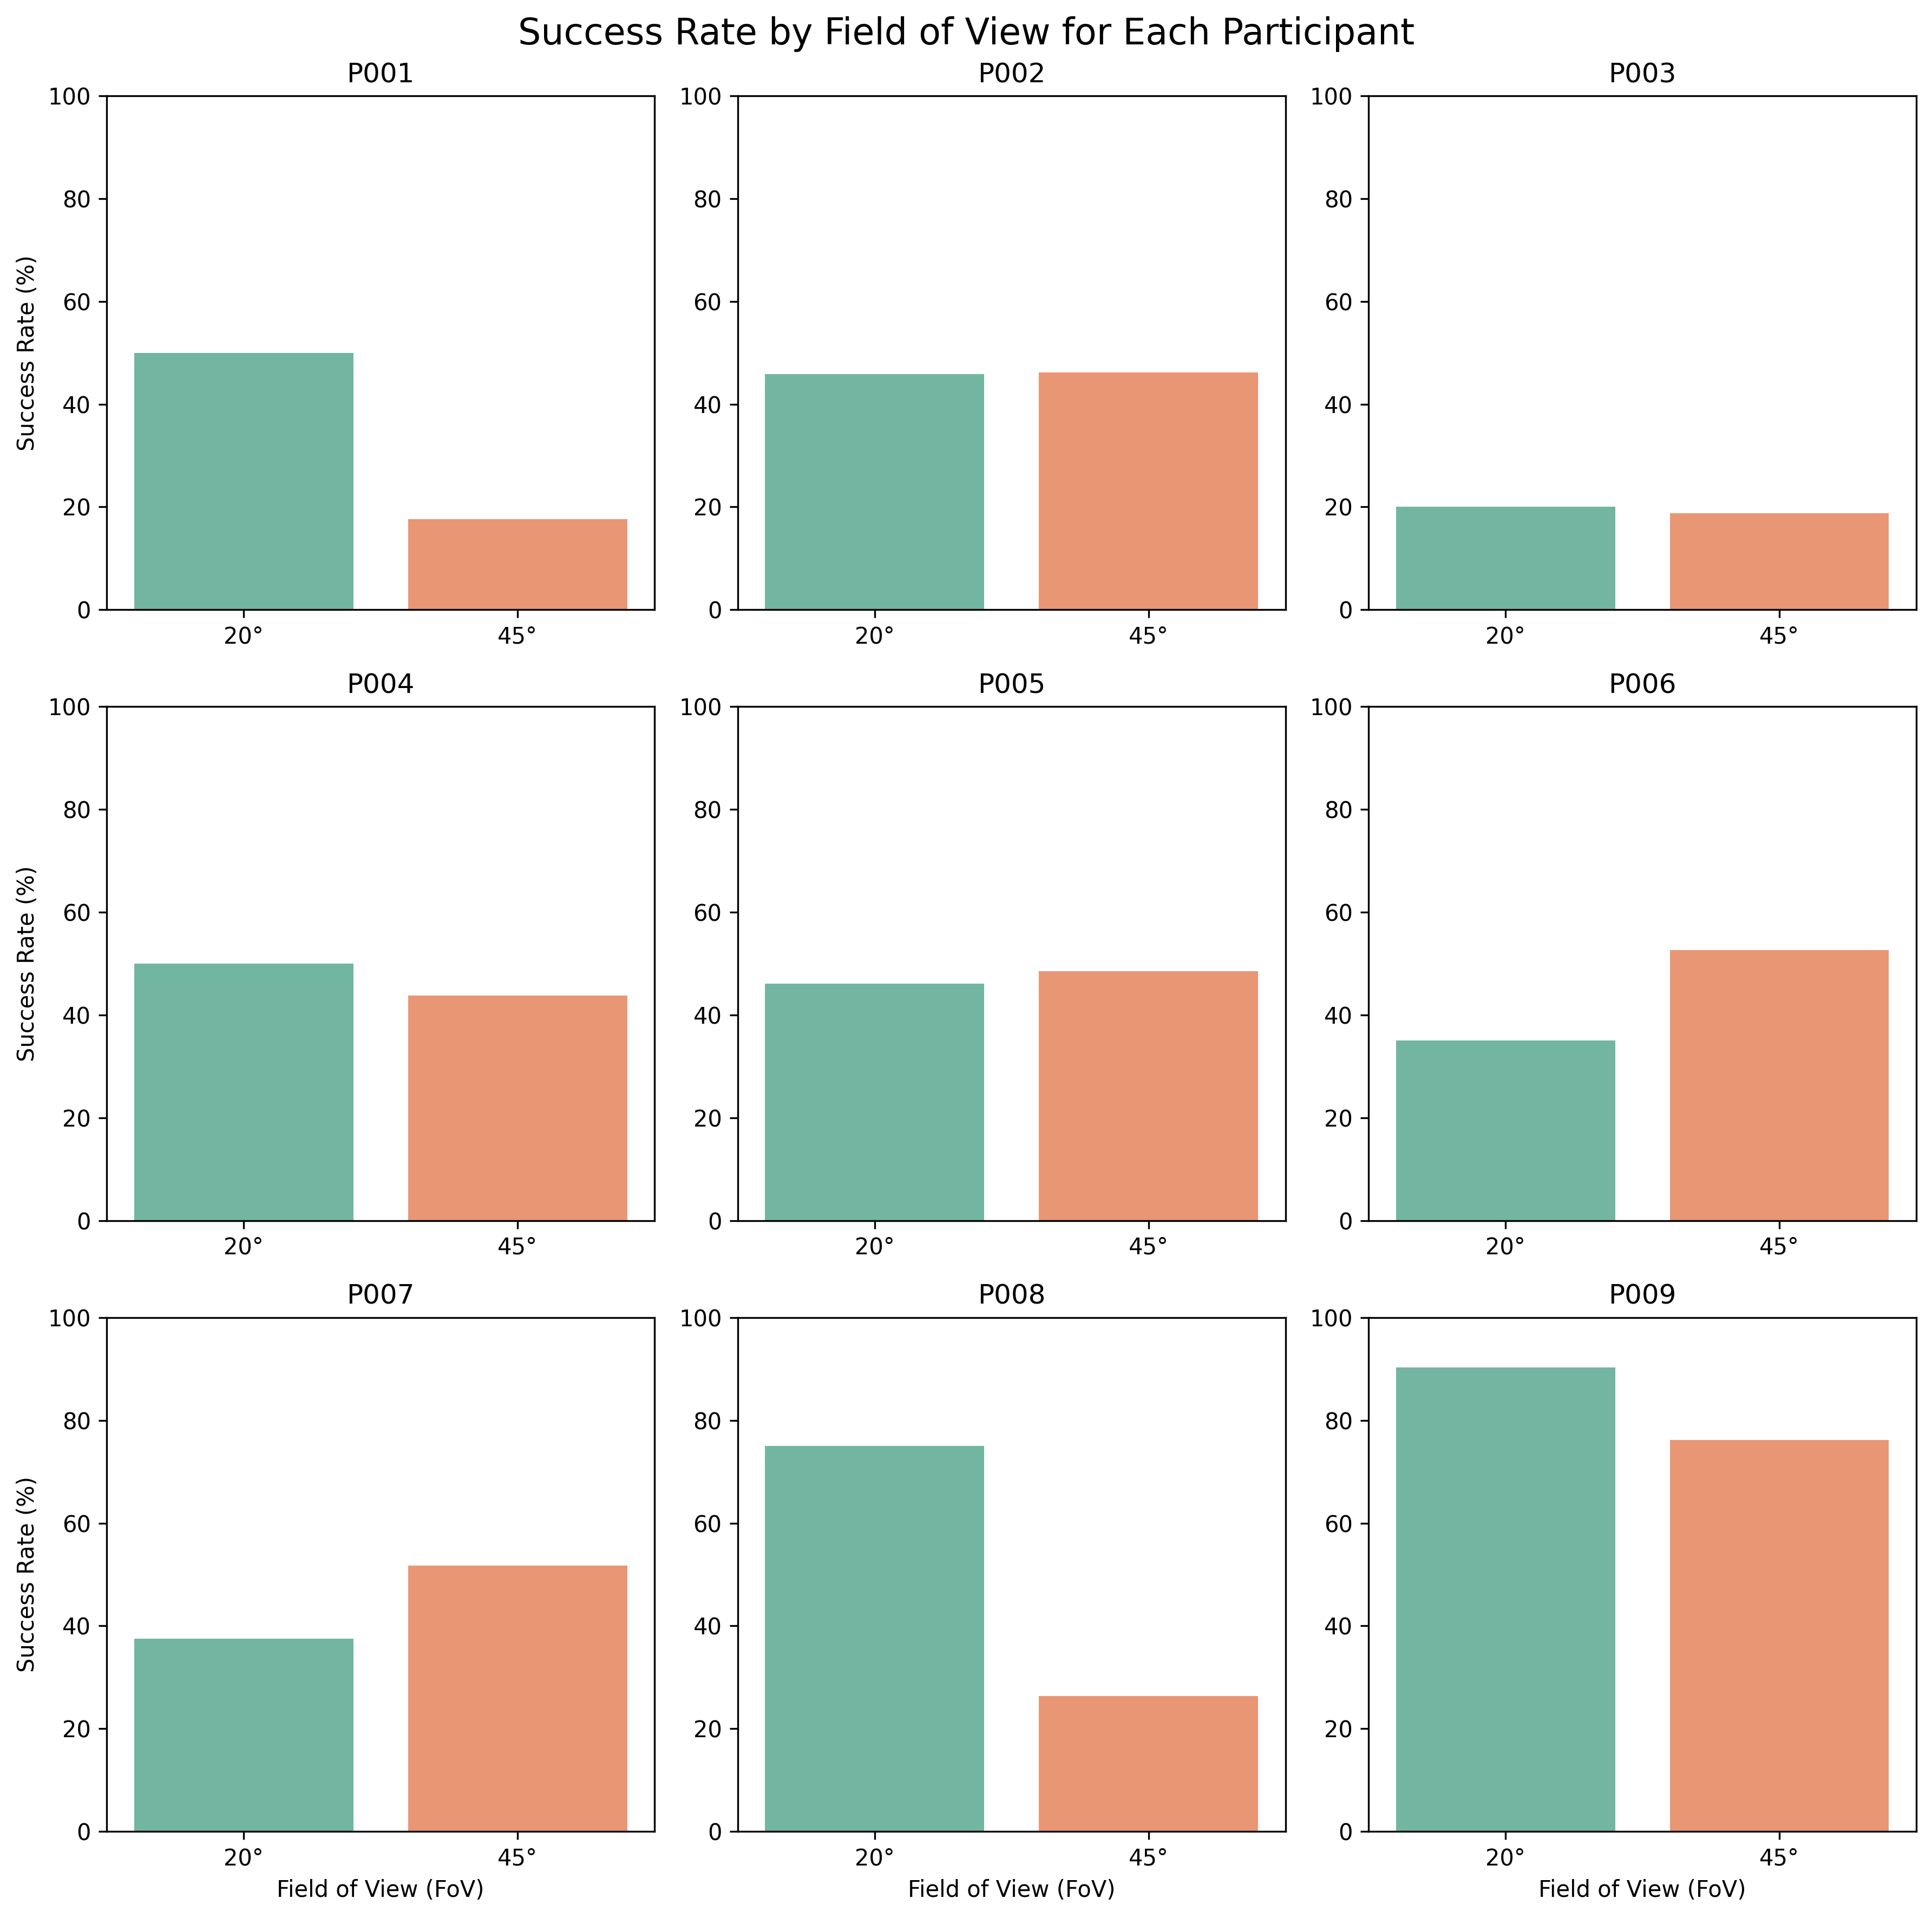

In [17]:
plot_accuracy(df_other_combined)

Success Rate comparison:
T-statistic: 0.5932179854814413
P-value: 0.5534431564090448

Reaction time comparison:
T-statistic: 2.8248724759950163
P-value: 0.004863599669070964
Means: 9.89 (20°), 9.13 (45°)


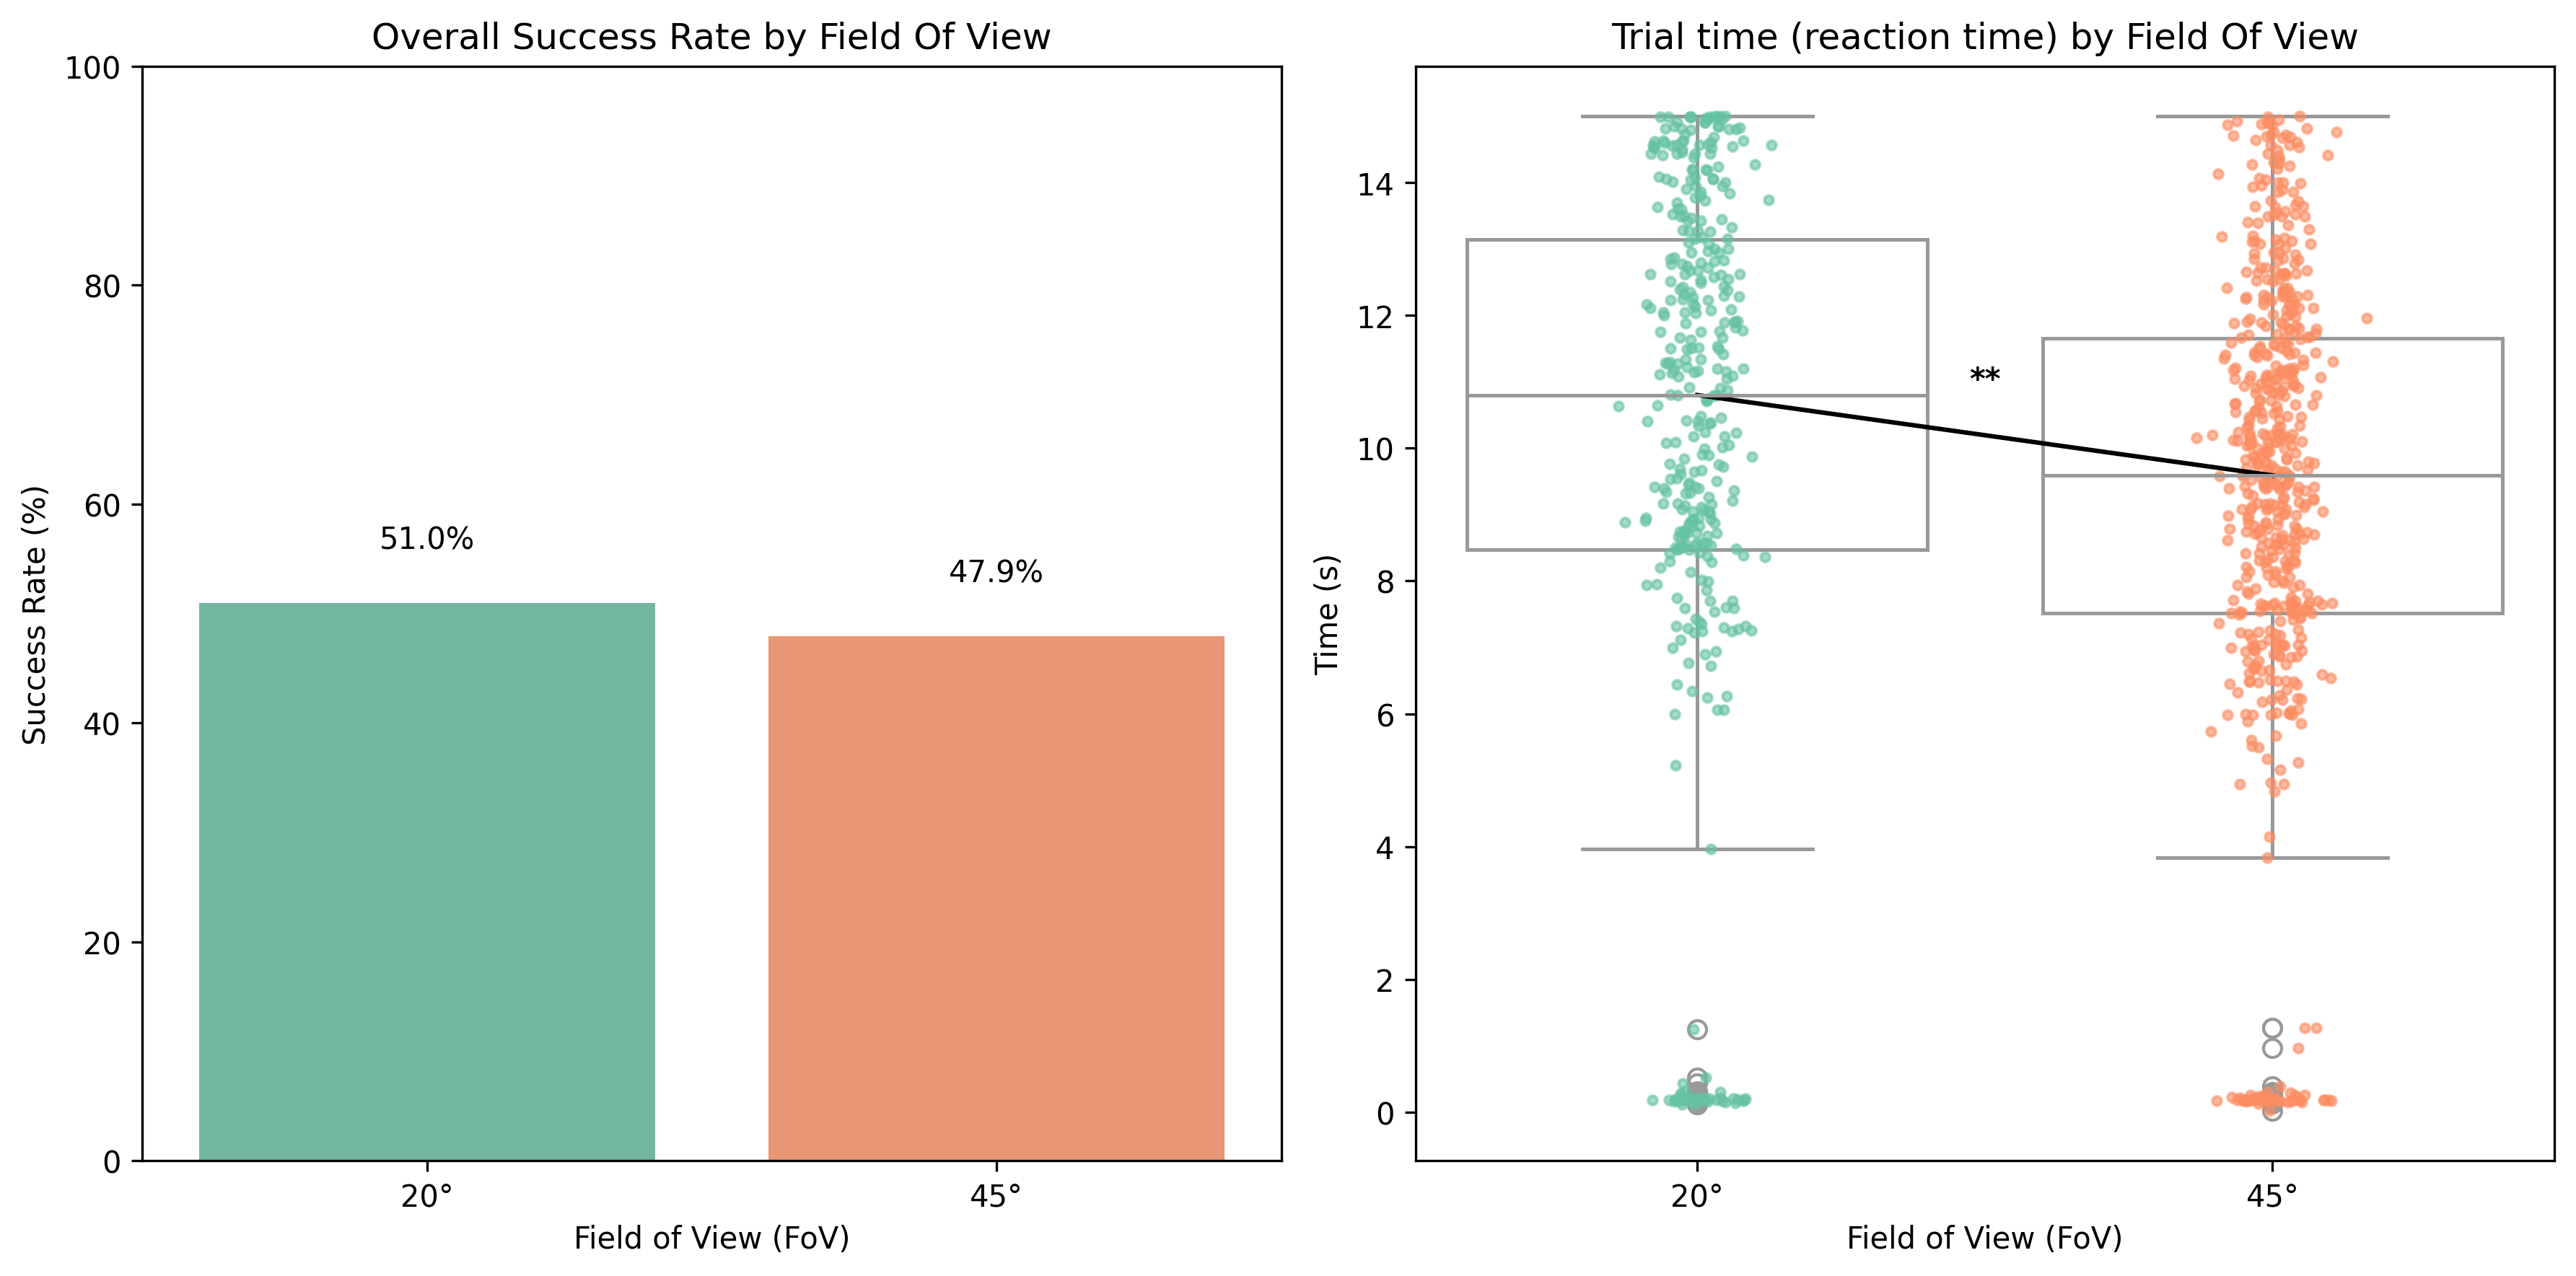

In [18]:
plot_combined_accuracy_and_boxplot(df_other_combined, df_start_trial_combined)